<a href="https://colab.research.google.com/github/csoren66/Credit-Card-Fraud-Detection/blob/main/6_Gradient_Descent_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 style="color:green" align="center">Implement Gradient Descent For Neural Network (or Logistic Regression)</h2>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('/content/insurance_data.csv')
df.head()

,age,affordibility,bought_insurance
0,22,1,0
1,25,0,0
2,47,1,1
3,52,0,0
4,46,1,1


In [3]:
df.shape

(28, 3)

**Split train and test set**

In [6]:
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['age','affordibility']], df.bought_insurance, test_size = 0.2, random_state = 2) 

In [7]:
len(X_train)

22

**Preprocessing: Scale the data so that both age and affordibility are in same scaling range**

In [8]:
X_train_scaled = X_train.copy()
X_train_scaled['age'] = X_train_scaled['age'] / 100

X_test_scaled = X_test.copy()
X_test_scaled['age'] = X_test_scaled['age'] / 100

In [9]:
X_train_scaled

,age,affordibility
16,0.25,0
6,0.55,0
3,0.52,0
21,0.26,0
26,0.23,1
25,0.54,1
12,0.27,0
4,0.46,1
10,0.18,1
5,0.56,1


**Model Building: First build a model in keras/tensorflow and see what weights and bias values it comes up with. We will than try to reproduce same weights and bias in our plain python implementation of gradient descent. Below is the architecture of our simple neural network**

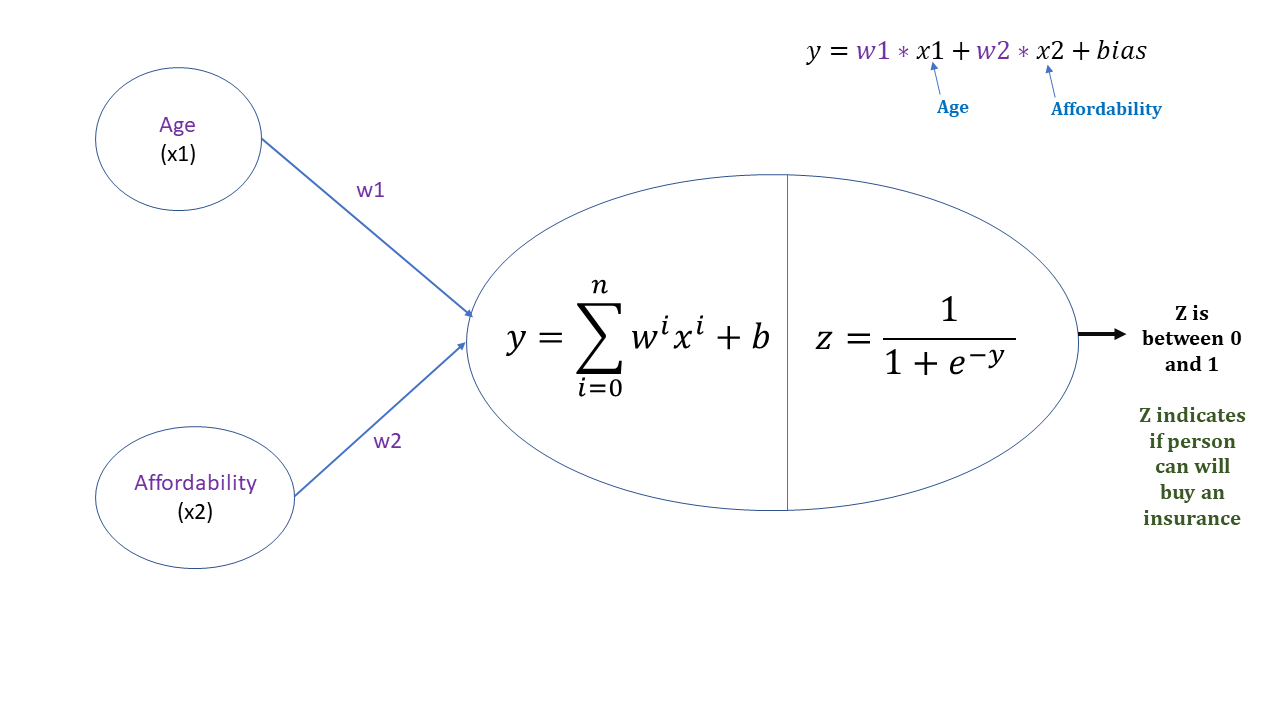

In [12]:
model = keras.Sequential([
    keras.layers.Dense(1, input_shape=(2,), activation='sigmoid', kernel_initializer='ones', bias_initializer='zeros')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=5000)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 18ms/step - loss: 0.5436 - accuracy: 0.7273
Epoch 2502/5000
1/1 [==============================] - 0s 18ms/step - loss: 0.5436 - accuracy: 0.7273
Epoch 2503/5000
1/1 [==============================] - 0s 8ms/step - loss: 0.5435 - accuracy: 0.7273
Epoch 2504/5000
1/1 [==============================] - 0s 10ms/step - loss: 0.5435 - accuracy: 0.7273
Epoch 2505/5000
1/1 [==============================] - 0s 9ms/step - loss: 0.5435 - accuracy: 0.7273
Epoch 2506/5000
1/1 [==============================] - 0s 10ms/step - loss: 0.5434 - accuracy: 0.7273
Epoch 2507/5000
1/1 [==============================] - 0s 8ms/step - loss: 0.5434 - accuracy: 0.7273
Epoch 2508/5000
1/1 [==============================] - 0s 7ms/step - loss: 0.5433 - accuracy: 0.7273
Epoch 2509/5000
1/1 [==============================] - 0s 10ms/step - loss: 0.5433 - accuracy: 0.7273
Epoch 2510/5000
1/1 [==============================

**Evaluate the model on test set**

In [14]:
model.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 136ms/step - loss: 0.3153 - accuracy: 1.0000


[0.31525877118110657, 1.0]

In [15]:
X_test_scaled

,age,affordibility
1,0.25,0
0,0.22,1
14,0.49,1
9,0.61,1
19,0.18,1
17,0.58,1


In [16]:
model.predict(X_test_scaled)

array([[0.16282055],
       [0.41183794],
       [0.7255057 ],
       [0.826683  ],
       [0.3651317 ],
       [0.8045075 ]], dtype=float32)

In [17]:
y_test

1     0
0     0
14    1
9     1
19    0
17    1
Name: bought_insurance, dtype: int64

In [18]:
coef, intercept = model.get_weights()
coef, intercept

(array([[4.9196706],
        [1.4286072]], dtype=float32), array([-2.8673074], dtype=float32))

**This means w1=5.060867, w2=1.4086502, bias =-2.9137027**


In [21]:
def sigmoid(x):
  import math
  return 1 / (1 + math.exp(-x))
sigmoid(18)


0.9999999847700205

In [22]:
def prediction_function(age, affordibility):
  weighted_sum = coef[0]*age + coef[1] * affordibility + intercept
  return sigmoid(weighted_sum)

In [25]:
prediction_function(.47,1)

0.7054827887279812

In [26]:
prediction_function(.18,1)

0.36513169769602194

**Now we start implementing gradient descent in plain python. Again the goal is to come up with same w1, w2 and bias that keras model calculated. We want to show how keras/tensorflow would have computed these values internally using gradient descent**

**First write couple of helper routines such as sigmoid and log_loss**

In [27]:
def sigmoid_numpy(X):
   return 1/(1+np.exp(-X))

sigmoid_numpy(np.array([12,0,1]))

array([0.99999386, 0.5       , 0.73105858])

In [28]:
def log_loss(y_true, y_predicted):
    epsilon = 1e-15
    y_predicted_new = [max(i,epsilon) for i in y_predicted]
    y_predicted_new = [min(i,1-epsilon) for i in y_predicted_new]
    y_predicted_new = np.array(y_predicted_new)
    return -np.mean(y_true*np.log(y_predicted_new)+(1-y_true)*np.log(1-y_predicted_new))

**All right now comes the time to implement our final gradient descent function !! yay !!!**


In [29]:
def gradient_descent(age, affordability, y_true, epochs, loss_thresold):
    w1 = w2 = 1
    bias = 0
    rate = 0.5
    n = len(age)
    for i in range(epochs):
        weighted_sum = w1 * age + w2 * affordability + bias
        y_predicted = sigmoid_numpy(weighted_sum)
        loss = log_loss(y_true, y_predicted)

        w1d = (1/n)*np.dot(np.transpose(age),(y_predicted-y_true)) 
        w2d = (1/n)*np.dot(np.transpose(affordability),(y_predicted-y_true)) 

        bias_d = np.mean(y_predicted-y_true)
        w1 = w1 - rate * w1d
        w2 = w2 - rate * w2d
        bias = bias - rate * bias_d

        print (f'Epoch:{i}, w1:{w1}, w2:{w2}, bias:{bias}, loss:{loss}')

        if loss<=loss_thresold:
            break

    return w1, w2, bias

In [30]:
gradient_descent(X_train_scaled['age'],X_train_scaled['affordibility'],y_train,1000, 0.4631)

Epoch:0, w1:0.973391914875179, w2:0.9484790550524685, bias:-0.11334365204477419, loss:0.714610156590683
Epoch:1, w1:0.9526050112606814, w2:0.9061888855737805, bias:-0.21202325373024938, loss:0.6844545754122794
Epoch:2, w1:0.9371389216394038, w2:0.8724863718378795, bias:-0.29735477734867394, loss:0.6623114062843336
Epoch:3, w1:0.9263972300850559, w2:0.8464964034855741, bias:-0.3708685783767046, loss:0.6463299135248588
Epoch:4, w1:0.9197530021886515, w2:0.8272363836850969, bias:-0.4341501414207024, loss:0.6349055537023248
Epoch:5, w1:0.9165978234998884, w2:0.8137152861544186, bias:-0.48872346395231214, loss:0.6267483980102484
Epoch:6, w1:0.9163723575035057, w2:0.804999539668341, bias:-0.5359802497218649, loss:0.6208785684684357
Epoch:7, w1:0.9185813941347364, w2:0.8002492021116546, bias:-0.5771466732016118, loss:0.6165824439197473
Epoch:8, w1:0.9227979840062284, w2:0.7987322635165252, bias:-0.6132761019356342, loss:0.6133562082414478
Epoch:9, w1:0.9286609028533963, w2:0.7998249643661494,

(5.776540098602374, 1.5072936283526548, -3.292466234362901)

In [31]:
coef, intercept

(array([[4.9196706],
        [1.4286072]], dtype=float32), array([-2.8673074], dtype=float32))

**This shows that in the end we were able to come up with same value of w1,w2 and bias using a plain python implementation of gradient descent function**
